In [1]:
import time

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import style

from more_itertools import chunked

from google.cloud import storage

In [2]:
# Configuration constants
VALIDATION_RATIO = 0.1

In [3]:
client = storage.Client()

bucket_name = "tdt4173-datasets"
bucket = client.get_bucket(bucket_name)

blobs = bucket.list_blobs()
for blob in blobs:
    print(blob.name)

cats-vs-dogs/
cats-vs-dogs/processed/catsvsdogs.npy
cats-vs-dogs/raw-data/
cats-vs-dogs/raw-data/catsanddogs.zip
cats-vs-dogs/tensors/
cats-vs-dogs/tensors/catsdogs_processed_64px_24946_horizontal.torch
celeba/
celeba/processed/
celeba/processed/celebalign_processed1.npy
celeba/tensors/
celeba/tensors/celebalign_processed_20_000_horizontal.torch
celeba/tensors/celebalign_processed_64_100000_horizontal.torch
celeba/zips/
celeba/zips/img_align_celeba.zip
celeba/zips/img_celeba.7z-20201107T135448Z-002.zip
celeba/zips/img_celeba.7z.001
checkpoints/FleetwoodNet11V1-1604934154/FleetwoodNet11V1-1604934154-epoch-0.data
checkpoints/FleetwoodNet11V1-1604934154/FleetwoodNet11V1-1604934154-epoch-1.data
checkpoints/FleetwoodNet11V1-1604934154/FleetwoodNet11V1-1604934154-epoch-2.data
checkpoints/FleetwoodNet11V1-1604934154/FleetwoodNet11V1-1604934154-epoch-3.data
checkpoints/FleetwoodNet11V1-1604934154/FleetwoodNet11V1-1604934154-epoch-4.data
faces/
faces/processed-images/
faces/videos/
tdt4173-data

In [5]:
blob_name = "cats-vs-dogs/tensors/catsdogs_processed_64px_24946_horizontal.torch"
blob = bucket.get_blob(blob_name)
data_file = "/home/jupyter/data/cats-vs-dogs/tensors/catsdogs_processed_64px_24946_horizontal.torch"
blob.download_to_filename(data_file)

In [6]:
# data_file = "/home/jupyter/data/celeb-align-1/tensors/celebalign_processed_100_000_horizontal.torch"
data = torch.load(data_file)

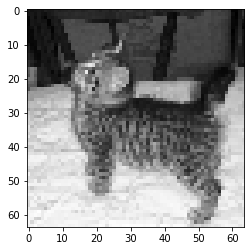

In [7]:
plt.imshow(data["x"][24], cmap="gray");

In [8]:
print(data["x"][0].shape)
IMAGE_SIZE = data["x"][0].shape[0]
NUM_CLASSES = data["num_classes"]

torch.Size([64, 64])


In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [10]:
unique = set(data["y"])
class_mapping = {elem: idx for idx, elem in enumerate(unique)}

In [11]:
val_size = int(len(data["x"]) * VALIDATION_RATIO)
print(val_size)

2494


In [12]:
train_x = data["x"][:-val_size]
train_y = data["y"][:-val_size]

In [13]:
def fwd_pass(x, y, loss_func, optim, train=False):
    if train:
        net.zero_grad()
        
    out = net(x)
    acc = np.mean([int(torch.argmax(y_pred) == y_real) for y_pred, y_real in zip(out, y)])
    loss = loss_func(out, y)

    if train:
        loss.backward()
        optim.step()

    return acc, loss

In [14]:
test_x = data["x"][-val_size:]
test_y = data["y"][-val_size:]

In [15]:
def test(size, loss_func, optim):
    tx, ty = test_x[:size].to(device), test_y[:size].to(device)
    val_acc, val_loss = fwd_pass(tx.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE).to(device), ty.to(device), loss_func, optim)
    return val_acc, val_loss

In [20]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import models.AnkiLeNet

import importlib
importlib.reload(models.AnkiLeNet)
NetClass = models.AnkiLeNet.AnkiLeNetV1

In [29]:
# Only run if need to delete memory
collect = False
if collect:
    import gc
    del net
    gc.collect()
    torch.cuda.empty_cache()

In [21]:
net = NetClass(NUM_CLASSES).to(device)
print(net)

AnkiLeNetV1(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [26]:
MODEL_NAME = f"{type(net).__name__}-{int(time.time())}"
print(f"Model name: {MODEL_NAME}")
saves_path = "/home/jupyter/checkpoints"
CHECKPOINT_EVERY_STEP = 10_000
SAVE_CHECKPOINTS = False

optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.NLLLoss().to(device)

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 10

    for epoch in range(EPOCHS):
        with open(os.path.join("/home/jupyter/logs", f"model-{MODEL_NAME}.log"), "a") as f:
            it = tqdm(range(0, len(train_x), BATCH_SIZE))
            for i in it:
                batch_x = train_x[i:i+BATCH_SIZE].view(-1, 1, IMAGE_SIZE, IMAGE_SIZE).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)

                acc, loss = fwd_pass(
                    batch_x, batch_y,
                    loss_function,
                    optimizer,
                    train=True,
                )
                
                it.set_postfix({"acc": acc, "loss": loss.item()})

                if i != 0 and i % CHECKPOINT_EVERY_STEP == 0:
                    val_acc, val_loss = test(size=100, loss_func=loss_function, optim=optimizer)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

            if SAVE_CHECKPOINTS:
                torch.save({
                                "model_state_dict": net.state_dict(),
                                "optimizer_state_dict": optimizer.state_dict(),
                                "val_acc": val_acc,
                                "val_loss": val_loss,
                            },
                    os.path.join(saves_path, f"{MODEL_NAME}-epoch-{epoch}.data"),
                )
            print(f"Epoch: {epoch}. Loss: {loss}. Accuracy: {acc}.")
train(net)

  1%|▏         | 3/225 [00:00<00:09, 23.82it/s, acc=0.43, loss=-.43]

Model name: AnkiLeNetV1-1604953942


  2%|▏         | 4/225 [00:00<00:06, 34.52it/s, acc=0.48, loss=-.48]

Epoch: 0. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


  2%|▏         | 4/225 [00:00<00:06, 34.20it/s, acc=0.48, loss=-.48]

Epoch: 1. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


  2%|▏         | 4/225 [00:00<00:06, 34.00it/s, acc=0.48, loss=-.48]

Epoch: 2. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


  2%|▏         | 4/225 [00:00<00:06, 33.86it/s, acc=0.48, loss=-.48]

Epoch: 3. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


  2%|▏         | 4/225 [00:00<00:06, 34.09it/s, acc=0.48, loss=-.48]

Epoch: 4. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


  2%|▏         | 4/225 [00:00<00:06, 33.80it/s, acc=0.48, loss=-.48]

Epoch: 5. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


  2%|▏         | 4/225 [00:00<00:06, 34.04it/s, acc=0.48, loss=-.48]

Epoch: 6. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


  2%|▏         | 4/225 [00:00<00:06, 33.80it/s, acc=0.48, loss=-.48]

Epoch: 7. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


  2%|▏         | 4/225 [00:00<00:06, 33.66it/s, acc=0.48, loss=-.48]

Epoch: 8. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


100%|██████████| 225/225 [00:06<00:00, 33.62it/s, acc=0.442, loss=-.442]

Epoch: 9. Loss: -0.4423076808452606. Accuracy: 0.4423076923076923.


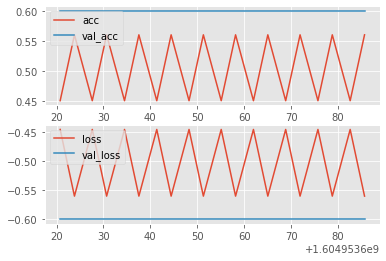

In [25]:
style.use("ggplot")
filename = "logs/model-AnkiLeNetV1-1604953942.log"


def create_acc_loss_graph(model_name):
    times = []
    accs = []
    losses = []
    
    val_accs = []
    val_losses = []
    
    with open(os.path.join("/home/jupyter", filename), "r") as f:
        
        for line in f.readlines():
            name, time, acc, loss, val_acc, val_loss = line.split(",")
            
            times.append(float(time))
            accs.append(float(acc))
            losses.append(float(loss))
            
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
            
    fig = plt.figure()
    
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)
    
    ax1.plot(times, accs, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(MODEL_NAME)

In [ ]:
# Not currently in use, I think
correct = 0

with torch.no_grad():
    for i, y_real in enumerate(tqdm(test_y)):
        real_class = torch.argmax(y_real)
        pred_class = torch.argmax(net(test_x[i].view(-1, 1, IMAGE_SIZE, IMAGE_SIZE))[0])
        
        correct += int(real_class == pred_class)
        
print(f"Accuracy: {round(correct / len(test_x), 3)}")

In [ ]:
for im in test_x:
    pred = int(torch.argmax(net(im.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE))))
    convert = {0: "Cat", 1: "Dog"}
    print(f"Net predicted it is `{convert[pred]}`")
    
    plt.imshow(im.cpu(),cmap="gray")
    plt.pause(0.05)
    print("="*50)